# Modeling XGBoost

In [91]:
# import
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import time
import sys

#Scikit Learn
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

from statsmodels.stats.outliers_influence import variance_inflation_factor


sys.path.insert(0, 'c:\\Users\\ingal\\Documents\\Data Science Work\\Data Scientist Take Home Exam - Recommendations')

%matplotlib inline

## 3.1 Load Data

In [29]:
tourism_df = pd.read_csv('../data/intermediate/cleaned_tourism.csv',index_col=0)
tourism_df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


## 3.2 Feature Engineering

In [30]:
# drop columns that don't pertain to the customer's attribute or are arbitrary for our model
tourism_df.drop(columns= ['TypeofContact','DurationOfPitch','NumberOfFollowups','PitchSatisfactionScore'], axis=1, inplace=True)

To categorize our customers, we care about when a profile was correctly pitched, not when it wasn't. So we filter for that. We also don't need CustomerID, the model shouldn't learn to predict based on ID numbers.

In [31]:
tourism_df = tourism_df[tourism_df['ProdTaken'] == 1].reset_index()
tourism_df.drop(columns = ['ProdTaken', 'CustomerID'], axis=1,inplace=True)

Remove Designation from the model as it was a 1:1 with the dependent variable, so it will train the model poorly.

In [32]:
tourism_df.drop(columns = ['Designation'], axis=1,inplace=True)

Dropping the Occupation column because the value definitions are unclear, they are imbalanced, and could have led to confusion during the process (do they work at a large business or own a large business? Where is hourly? etc.)

In [33]:
tourism_df.drop(columns = ['Occupation'], axis=1,inplace=True)

## 3.3 Data Split

This is a textbook example of Mult-Class Classification. A customer can only belong to one product, we do not want to pitch multiple products for them.

In [34]:
tourism_df
X_df = tourism_df.drop(columns=['ProductPitched'],axis=1)
# dummy variables for Gender, MaritalStatus, and Designation
X_df = pd.get_dummies(X_df)

One-hot encode the categorical features that are numerical. This will help avoid any sort of ranking in the model. 

Features: CityTier and PreferredPropertyStar

In [35]:
X_df = pd.get_dummies(X_df, columns=['CityTier','PreferredPropertyStar']).drop(columns=['index'],axis=1)

In [36]:
# turn X into np array of values
X = X_df.values
X

array([[41.,  3.,  1., ...,  1.,  0.,  0.],
       [37.,  3.,  7., ...,  1.,  0.,  0.],
       [28.,  2.,  6., ...,  1.,  0.,  0.],
       ...,
       [52.,  4.,  7., ...,  0.,  1.,  0.],
       [19.,  3.,  3., ...,  1.,  0.,  0.],
       [36.,  4.,  3., ...,  0.,  1.,  0.]])

In [37]:
# for y values we will use LabelEncoder from SciKit Learn to turn the categories into numerical values
le = LabelEncoder()
le.fit(tourism_df['ProductPitched'])
y = le.transform(tourism_df['ProductPitched'])

In [38]:
# these are the classes that we changed into values
le.classes_

array(['Basic', 'Deluxe', 'King', 'Standard', 'Super Deluxe'],
      dtype=object)

In [39]:
# the transformed array from text to numerical
y

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 3, 0, 0, 3, 0, 0, 1, 1, 0, 1, 3,
       0, 1, 3, 0, 0, 0, 0, 1, 1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 3, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2,
       1, 0, 0, 1, 2, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3,
       3, 0, 4, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 3, 3, 3, 1,
       0, 0, 0, 0, 1, 4, 0, 1, 0, 3, 4, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 3,
       0, 1, 0, 3, 3, 0, 0, 3, 4, 0, 1, 1, 0, 1, 3, 0, 0, 0, 3, 0, 3, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 3, 1, 0, 1, 0, 0, 0,
       0, 0, 4, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 2, 3, 0, 0, 3, 0, 0, 1, 1, 0, 1, 3, 0, 1, 3, 0, 0,
       0, 0, 1, 1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,

## 3.4 Custom Transformers for Preprocessing Functions

I had some functions I was using for unique and specific imputation. They will be valuable for the model performance, rather than just using SimpleImputation.

In [40]:
class LowerSalaryAgeImputation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self,X):

        df = pd.DataFrame(X)

        low_income_age = round(df[df[6] > 19000][0].mean(), 0)

        mask =  (df[0].isna()) & (df[6] < 19000)    

        df.loc[mask,0] = low_income_age
    
        return df.values

In [41]:
class ByAgeIncomeImputation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self,X):

        df = pd.DataFrame(X)

        income_by_age = df.groupby([0])[6].agg(['median']).reset_index()

   
        for index, age in enumerate(income_by_age[0]):
            mask = (df[6].isna()) & (df[0] == age)    

            df.loc[mask,[6]] = income_by_age['median'].loc[index]
    
        return df.values
    

## 3.5 Model Selection

I will be using XGBoost for my model choice. Since the assignment doesn't want me to check out different models, I prefer to use an ensemble model, which generally performs better than an individual model. Then when choosing between Random Forest (another ensemble) and XGBoost, generally XGBoost is faster. Additionally, since boosting has better performance than bagging (Random Forest), I will choose the better on average of the two models. XGBoost is currently one of the best ensemble methods available. Additionally, XGBoost's default models are regularized, so overfitting is more difficult. Finally, XGBoost has hyperparameters to scale imbalanced data, which we definitely have so this will be a great Algorithm for this project. 

We will be using the Scikit-learn wrapper for XGBoost: XGBClassifier. Additionally, we will create a ML pipeline using Scikit-learn so we can perform our NaN fills on the partitioned dataset to avoid the data leakage.

In [42]:
# Training/Testing Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
# create a pipeline 

pipeline = Pipeline([
    ('Age_low_salary_NaN',LowerSalaryAgeImputation()),
    ('Income_NaN',ByAgeIncomeImputation()),
    ('Children_Trips_Star_NaN',SimpleImputer(strategy = 'median')),
    ('Standard_Scalar',StandardScaler()), 
    ('model', XGBClassifier())
])

### Baseline Model

In [44]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('Age_low_salary_NaN', LowerSalaryAgeImputation()),
                ('Income_NaN', ByAgeIncomeImputation()),
                ('Children_Trips_Star_NaN', SimpleImputer(strategy='median')),
                ('Standard_Scalar', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_roun...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, ...))])

In [45]:
y_pred = pipeline.predict(X_test)

In [46]:
# Plot confusion matrix
def confusionMatrix(y_test,y_pred):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"], 
    )

    cmp.plot(ax=ax)
    plt.show();
    return

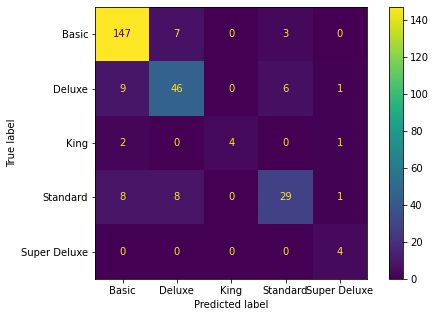

In [47]:
confusionMatrix(y_test,y_pred)

#### Precision/Recall F1 Scores

Since we have a high class imbalance, F1 scores are the right choice for our metric as it considers both precision and recall. To get a high F1, both false positives and false negatives must be low. Other measures of performance for classification my give us high scores with a high enough number of false positives. 

In [48]:
print(classification_report(y_test, y_pred, target_names=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"]))

              precision    recall  f1-score   support

       Basic       0.89      0.94      0.91       157
      Deluxe       0.75      0.74      0.75        62
        King       1.00      0.57      0.73         7
    Standard       0.76      0.63      0.69        46
Super Deluxe       0.57      1.00      0.73         4

    accuracy                           0.83       276
   macro avg       0.79      0.78      0.76       276
weighted avg       0.83      0.83      0.83       276



Here, we look at the individual f1 scores, but also more imporantly the macro avg. 
- While it seems intuitive that we would want to weight our F1 score based on the number of occurances in our imbalance dataset, because the dataset is imbalanced is exactly why we need to use the Macro score instead of the weighted score.
- The Macro score treats all classes equally and since all our packages are equally important (regardless of occurance count), this is our preferred metric.

### Cross-Validation

In [49]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1,error_score="raise")
# summarize performance
print('Mean F1 macro: %.5f' % mean(scores))

Mean F1 macro: 0.77954


## 3.6 Feature Selection

The next phase is to remove and unecessary or duplicative features to streamline the productivity of our model.

### Feature Significance

The following graph will show us the level of importance or contribution each feature has to our baseline model. With this we can prune any unused or harmful features. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

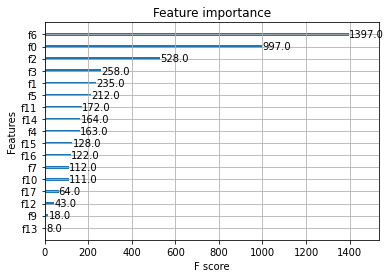

In [50]:
plot_importance(pipeline.steps[4][1])

1. Monthly Income
2. Age
3. NumberOfTrips
4. Passport
5. NumberOfPersonVisiting
6. Number of ChildrenVisiting
7. MaritalStatus_Single
8. OwnCar
9. CityTier3
10. PreferredPropertyStar_3
11. MaritalStatus_Married
12. Gender_Female
13. PreferredPropertyStar_4.0
14. PreferredPropertyStar_5.0
15. CityTier_1
16. CityTier_2
17. MaritalStatus_Divorced


#### Multicollinearity

Here we are checking if any features are correlated to others. If they are, we can remove one of them because they will have the same impact on the model.

In [51]:
corr=X_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,NumberOfPersonVisiting,NumberOfTrips,Passport,OwnCar,NumberOfChildrenVisiting,MonthlyIncome,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,CityTier_1,CityTier_2,CityTier_3,PreferredPropertyStar_3.0,PreferredPropertyStar_4.0,PreferredPropertyStar_5.0
Age,1.000000,0.061713,0.093434,-0.006912,0.068902,0.063468,0.502517,-0.050635,0.050635,0.065152,0.151519,-0.189633,-0.041824,-0.053792,0.066754,0.054815,-0.007901,-0.084855
NumberOfPersonVisiting,0.061713,1.000000,0.187754,0.045721,0.041352,0.621791,0.312351,0.046451,-0.046451,0.027067,-0.015456,-0.003701,0.055637,-0.023427,-0.046194,-0.096752,0.029670,0.066461
NumberOfTrips,0.093434,0.187754,1.000000,0.000556,-0.013116,0.207184,0.120667,-0.085630,0.085630,0.015289,0.069034,-0.076477,0.017902,-0.044298,0.001524,0.002800,-0.044556,0.025582
Passport,-0.006912,0.045721,0.000556,1.000000,0.032625,0.040108,-0.061643,0.001628,-0.001628,0.021815,-0.023005,0.007110,0.047415,-0.047009,-0.027252,0.075017,0.034332,-0.113876
OwnCar,0.068902,0.041352,-0.013116,0.032625,1.000000,0.038796,0.158618,-0.000801,0.000801,0.081666,-0.002024,-0.053852,-0.038286,0.020438,0.029854,-0.024042,0.040351,-0.015890
NumberOfChildrenVisiting,0.063468,0.621791,0.207184,0.040108,0.038796,1.000000,0.274998,0.040020,-0.040020,-0.031478,0.040432,-0.017249,-0.052204,-0.012860,0.058981,-0.050766,0.046049,0.004832
MonthlyIncome,0.502517,0.312351,0.120667,-0.061643,0.158618,0.274998,1.000000,0.006787,-0.006787,0.042523,0.064918,-0.091152,-0.151270,-0.014132,0.160407,-0.021449,-0.021328,-0.010261
Gender_Female,-0.050635,0.046451,-0.085630,0.001628,-0.000801,0.040020,0.006787,1.000000,-1.000000,0.012543,-0.052604,0.041766,-0.105734,0.050568,0.085079,-0.077362,0.148737,-0.050230
Gender_Male,0.050635,-0.046451,0.085630,-0.001628,0.000801,-0.040020,-0.006787,-1.000000,1.000000,-0.012543,0.052604,-0.041766,0.105734,-0.050568,-0.085079,0.077362,-0.148737,0.050230
MaritalStatus_Divorced,0.065152,0.027067,0.015289,0.021815,0.081666,-0.031478,0.042523,0.012543,-0.012543,1.000000,-0.292395,-0.403364,0.050808,-0.032130,-0.037375,0.076700,-0.084140,-0.019288


- Children vs. Person : 62%
- Monthly Income vs. Age: 50%
- Male vs Female: 100%
- Married vs Single: 75%
- Single vs Divorsed 40%

### Feature Selection

- Any dummy feature with all dummies under top 10 significance will be removed: **PreferredPropertyStar** and **CityTier**
- **MaritalStatus_Married** will be removed as it has high collinearity with single and divorced (if you aren't single or divorced, you are married according to this survey)
- **Gender_Male** will be removed as it has high collinearity with **Gender_Female**. According to this survey, gender is binary so Gender_Male is just a redundent feature.
- **NumberOfChildrenVisiting** will be removed as it has high collinearity with **NumberOfPersonVisiting**. Most likely, Children is included in PersonVisiting so it would be double counting.

In [52]:
X_sig = X_df[['Age', 'NumberOfPersonVisiting', 'NumberOfTrips', 'Passport', 'OwnCar', 'Gender_Female','MonthlyIncome','MaritalStatus_Divorced', 'MaritalStatus_Single']]

These are our remaining features.

### Collinearity after feature selection

In [53]:
corr=X_sig.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,NumberOfPersonVisiting,NumberOfTrips,Passport,OwnCar,Gender_Female,MonthlyIncome,MaritalStatus_Divorced,MaritalStatus_Single
Age,1.000000,0.061713,0.093434,-0.006912,0.068902,-0.050635,0.502517,0.065152,-0.189633
NumberOfPersonVisiting,0.061713,1.000000,0.187754,0.045721,0.041352,0.046451,0.312351,0.027067,-0.003701
NumberOfTrips,0.093434,0.187754,1.000000,0.000556,-0.013116,-0.085630,0.120667,0.015289,-0.076477
Passport,-0.006912,0.045721,0.000556,1.000000,0.032625,0.001628,-0.061643,0.021815,0.007110
OwnCar,0.068902,0.041352,-0.013116,0.032625,1.000000,-0.000801,0.158618,0.081666,-0.053852
Gender_Female,-0.050635,0.046451,-0.085630,0.001628,-0.000801,1.000000,0.006787,0.012543,0.041766
MonthlyIncome,0.502517,0.312351,0.120667,-0.061643,0.158618,0.006787,1.000000,0.042523,-0.091152
MaritalStatus_Divorced,0.065152,0.027067,0.015289,0.021815,0.081666,0.012543,0.042523,1.000000,-0.403364
MaritalStatus_Single,-0.189633,-0.003701,-0.076477,0.007110,-0.053852,0.041766,-0.091152,-0.403364,1.000000


In [54]:
X_sig = X_sig.values

### Model Test Post-Feature Selection

In [55]:
# Training/Testing Split

X_train, X_test, y_train, y_test = train_test_split(X_sig, y, test_size=0.3, random_state=42)

In [56]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

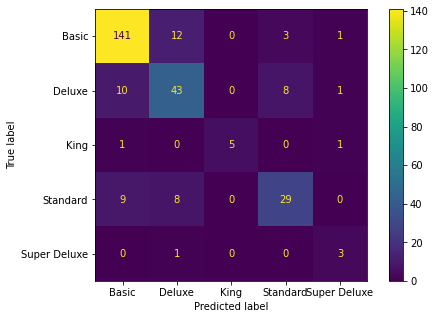

In [57]:
confusionMatrix(y_test,y_pred)

In [58]:
print(classification_report(y_test, y_pred, target_names=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"]))

              precision    recall  f1-score   support

       Basic       0.88      0.90      0.89       157
      Deluxe       0.67      0.69      0.68        62
        King       1.00      0.71      0.83         7
    Standard       0.72      0.63      0.67        46
Super Deluxe       0.50      0.75      0.60         4

    accuracy                           0.80       276
   macro avg       0.75      0.74      0.74       276
weighted avg       0.80      0.80      0.80       276



In [59]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='f1_macro', cv=cv, n_jobs=-1,error_score="raise")
# summarize performance
print('Mean F1 macro: %.5f' % mean(scores))

Mean F1 macro: 0.77954


With our current feature selection there isn't much of a drop in performance (if any)! Let move onto hyperparameter tunning using GridSearchCV

## 3.7 Hyperparameter Tuning

Create a new pipeline for gridsearch. This way we will always have the basemodel pipeline, and can change or add to this pipeline if we wish.
- Since GridSearchCV can take a lot longer each parameter you add, I have chosen 5 parameters from XGBoost that I have researched and used in the past with considerable success.

In [60]:
cv_pipeline = Pipeline([
    ('Age_low_salary_NaN',LowerSalaryAgeImputation()),
    ('Income_NaN',ByAgeIncomeImputation()),
    ('Children_Trips_Star_NaN',SimpleImputer(strategy = 'median')),
    ('Standard_Scalar',StandardScaler()), 
    ('model', XGBClassifier())
])

In [61]:
# find parameters

cv_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Age_low_salary_NaN', 'Income_NaN', 'Children_Trips_Star_NaN', 'Standard_Scalar', 'model', 'Children_Trips_Star_NaN__add_indicator', 'Children_Trips_Star_NaN__copy', 'Children_Trips_Star_NaN__fill_value', 'Children_Trips_Star_NaN__missing_values', 'Children_Trips_Star_NaN__strategy', 'Children_Trips_Star_NaN__verbose', 'Standard_Scalar__copy', 'Standard_Scalar__with_mean', 'Standard_Scalar__with_std', 'model__objective', 'model__use_label_encoder', 'model__base_score', 'model__booster', 'model__callbacks', 'model__colsample_bylevel', 'model__colsample_bynode', 'model__colsample_bytree', 'model__early_stopping_rounds', 'model__enable_categorical', 'model__eval_metric', 'model__gamma', 'model__gpu_id', 'model__grow_policy', 'model__importance_type', 'model__interaction_constraints', 'model__learning_rate', 'model__max_bin', 'model__max_cat_to_onehot', 'model__max_delta_step', 'model__max_depth', 'model__max_leaves', 'model__min_child_weight', 'mod

### Hypertuning Parameters with GridSearch


In [89]:
parameters = {
        'model__learning_rate' : [0.01,0.1, 0.2,0.3],
        'model__subsample' : [0.25,0.5,1],
        'model__max_depth' : [2,3,4,5,6],
        'model__n_estimators': [100,250,400,500]
    }

GS = GridSearchCV(cv_pipeline, param_grid=parameters, scoring='f1_macro', n_jobs=-1, cv=5)

In [90]:
GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Age_low_salary_NaN',
                                        LowerSalaryAgeImputation()),
                                       ('Income_NaN', ByAgeIncomeImputation()),
                                       ('Children_Trips_Star_NaN',
                                        SimpleImputer(strategy='median')),
                                       ('Standard_Scalar', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsamp...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'model__max_depth': [2, 3, 4, 5, 6],
                         'model__n_estimators': [100, 250, 400, 500],
                         'model__subsample': [0.25, 0.5, 1]},
             scoring='f1_macro')

In [92]:
y_pred = GS.predict(X_test)

In [93]:
GS.best_params_

{'model__learning_rate': 0.3,
 'model__max_depth': 5,
 'model__n_estimators': 400,
 'model__subsample': 0.5}

### Hyperparameter Model Update

In [82]:
# Training/Testing Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
#create a pipeline 

pipeline_best = Pipeline([
    ('Age_low_salary_NaN',LowerSalaryAgeImputation()),
    ('Income_NaN',ByAgeIncomeImputation()),
    ('Children_Trips_Star_NaN',SimpleImputer(strategy = 'median')),
    ('Standard_Scalar',StandardScaler()), 
    ('model', XGBClassifier(learning_rate= 0.3, max_depth= 5, subsample = 0.5, n_estimators = 400))
])

In [95]:
pipeline_best.fit(X_train,y_train)

Pipeline(steps=[('Age_low_salary_NaN', LowerSalaryAgeImputation()),
                ('Income_NaN', ByAgeIncomeImputation()),
                ('Children_Trips_Star_NaN', SimpleImputer(strategy='median')),
                ('Standard_Scalar', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_roun...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.3, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=400, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, ...))])

In [96]:
y_pred = pipeline_best.predict(X_test)

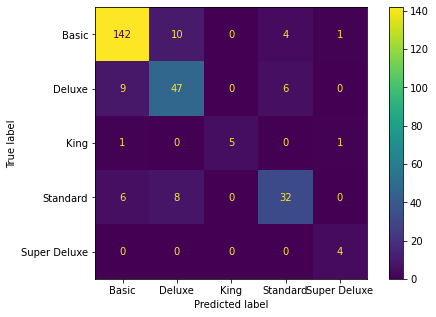

In [97]:
confusionMatrix(y_test,y_pred)

#### Precision/Recall F1 Scores

Since we have a high class imbalance, F1 scores are the right choice for our metric as it considers both precision and recall. To get a high F1, both false positives and false negatives must be low. Other measures of performance for classification my give us high scores with a high enough number of false positives. 

In [98]:
print(classification_report(y_test, y_pred, target_names=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"]))

              precision    recall  f1-score   support

       Basic       0.90      0.90      0.90       157
      Deluxe       0.72      0.76      0.74        62
        King       1.00      0.71      0.83         7
    Standard       0.76      0.70      0.73        46
Super Deluxe       0.67      1.00      0.80         4

    accuracy                           0.83       276
   macro avg       0.81      0.81      0.80       276
weighted avg       0.84      0.83      0.83       276



### Cross-Validation

In [99]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline_best, X, y, scoring='f1_macro', cv=cv, n_jobs=-1,error_score="raise")
# summarize performance
print('Mean F1 Macro: %.5f' % mean(scores))

Mean F1 Macro: 0.77873


Well GridSearch came back with basically the same model as before. We will try a different search method to see if that improves our tuning.

### Random Search 

In [140]:
param_dist = {
        'model__learning_rate' : np.arange(0.1,0.3, 0.01),
        'model__subsample' : np.arange(0.1, 1, 0.1),
        'model__max_depth' : np.arange(2,10,1),
        'model__n_estimators': np.arange(100,1000,100)
    }

In [141]:
RS = RandomizedSearchCV(cv_pipeline, param_distributions=param_dist, n_iter=500,scoring='f1_macro', n_jobs=-1, cv=5)

In [142]:
RS.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('Age_low_salary_NaN',
                                              LowerSalaryAgeImputation()),
                                             ('Income_NaN',
                                              ByAgeIncomeImputation()),
                                             ('Children_Trips_Star_NaN',
                                              SimpleImputer(strategy='median')),
                                             ('Standard_Scalar',
                                              StandardScaler()),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            c...
                   n_iter=500, n_jobs=-1,
                   param_distributions={'model__learning_rate': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                        'model__max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'model__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'model__subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='f1_macro')

In [143]:
RS.best_params_

{'model__subsample': 0.4,
 'model__n_estimators': 700,
 'model__max_depth': 6,
 'model__learning_rate': 0.17999999999999997}

In [133]:
RS.best_score_

0.7553342476314031

In [144]:
#create a pipeline 

pipeline_best_RS = Pipeline([
    ('Age_low_salary_NaN',LowerSalaryAgeImputation()),
    ('Income_NaN',ByAgeIncomeImputation()),
    ('Children_Trips_Star_NaN',SimpleImputer(strategy = 'median')),
    ('Standard_Scalar',StandardScaler()), 
    ('model', XGBClassifier(learning_rate= 0.17999999999999997, max_depth= 6, subsample = 0.4, n_estimators = 700))
])

In [145]:
pipeline_best_RS.fit(X_train,y_train)

Pipeline(steps=[('Age_low_salary_NaN', LowerSalaryAgeImputation()),
                ('Income_NaN', ByAgeIncomeImputation()),
                ('Children_Trips_Star_NaN', SimpleImputer(strategy='median')),
                ('Standard_Scalar', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_roun...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.17999999999999997, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=700, n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, ...))])

In [146]:
y_pred = pipeline_best_RS.predict(X_test)

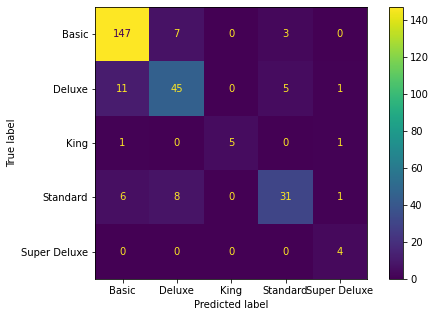

In [147]:
confusionMatrix(y_test,y_pred)

#### Precision/Recall F1 Scores

Since we have a high class imbalance, F1 scores are the right choice for our metric as it considers both precision and recall. To get a high F1, both false positives and false negatives must be low. Other measures of performance for classification my give us high scores with a high enough number of false positives. 

In [148]:
print(classification_report(y_test, y_pred, target_names=["Basic", "Deluxe", "King", "Standard", "Super Deluxe"]))

              precision    recall  f1-score   support

       Basic       0.89      0.94      0.91       157
      Deluxe       0.75      0.73      0.74        62
        King       1.00      0.71      0.83         7
    Standard       0.79      0.67      0.73        46
Super Deluxe       0.57      1.00      0.73         4

    accuracy                           0.84       276
   macro avg       0.80      0.81      0.79       276
weighted avg       0.84      0.84      0.84       276



### Cross-Validation

In [149]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline_best_RS, X, y, scoring='f1_macro', cv=cv, n_jobs=-1,error_score="raise")
# summarize performance
print('Mean F1 Macro: %.5f' % mean(scores))

Mean F1 Macro: 0.79000


## 3.8 Save Model